In [1]:
import torch
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
SOS_token = 0
EOS_token = 1

class DataPreproccessing:
    def __init__(self, name):
        self.name = name        
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:            
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [3]:
import regex as re
import unicodedata
import string

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub("(\\W)"," ",text) 
    text = re.sub('\S*\d\S*\s*','', text)
    return text

In [4]:
from pathlib import Path
path_downloads = Path.home() / "Downloads"

In [5]:
# data was all wrong repeating values of answers in questions, below you will find a better dataset with better results

In [6]:
name_data = 'cleaned_data.txt'
url_train = path_downloads / name_data

In [7]:
def read_lines(input, output, url_train, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(url_train, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[clean_text(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input = DataPreproccessing(output)
        output = DataPreproccessing(input)
    else:
        input = DataPreproccessing(input)
        output = DataPreproccessing(output)

    return input, output, pairs

In [8]:
MAX_LENGTH = 22

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [9]:
def prepareData(url_train, input, output, reverse=False):
    input, output, pairs = read_lines(input, output, url_train, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input.addSentence(pair[0])
        output.addSentence(pair[1])
    print("Counted words:")
    print(input.name, input.n_words)
    print(output.name, output.n_words)
    return input, output, pairs

input, output, pairs = prepareData(url_train, 'questions', 'answers', False)
print(random.choice(pairs))

Reading lines...
Read 350 sentence pairs
Trimmed to 350 sentence pairs
Counting words...
Counted words:
questions 569
answers 463
['did you go to school today', 'yeah i went to school today were you there']


In [10]:
pairs.pop(0)

['questions', 'answers']

In [11]:
train_df = pd.DataFrame(pairs, columns=['questions', 'answers'])  # 90% of the data was wrong
display(train_df)

questions  \
0                            hello how are you   
1                         hi how are you doing   
2                              how is it going   
3                      how are you doing today   
4                      it is an ugly day today   
..                                         ...   
344                      do not pick your nose   
345                    our tv remote is filthy   
346                       my ear is killing me   
347    did you see the woman with the new face   
348  theres something wrong with my right hand   

                             answers  
0            i am good how about you  
1       i am fine how about yourself  
2      i am doing well how about you  
3    i am doing great what about you  
4         i know i think it may rain  
..                               ...  
344        i was not picking my nose  
345      yes it is covered with crud  
346               that is the matter  
347           did she get a nice job  
348            that is wrong with it  

[349 rows x 2 columns]

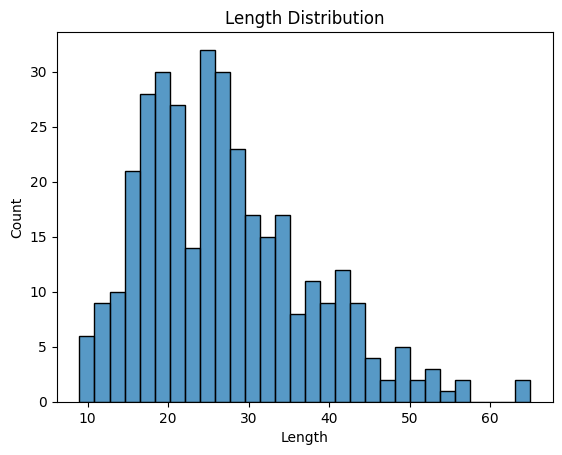

In [81]:
sns.histplot(data=train_df['questions'].str.len(), bins=30)
plt.title('Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

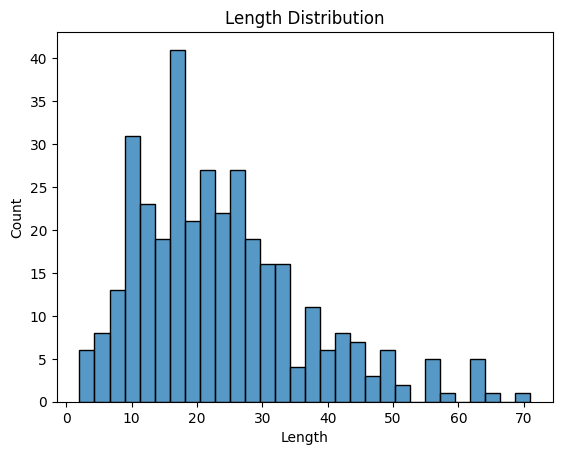

In [82]:
sns.histplot(data=train_df['answers'].str.len(), bins=30)
plt.title('Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

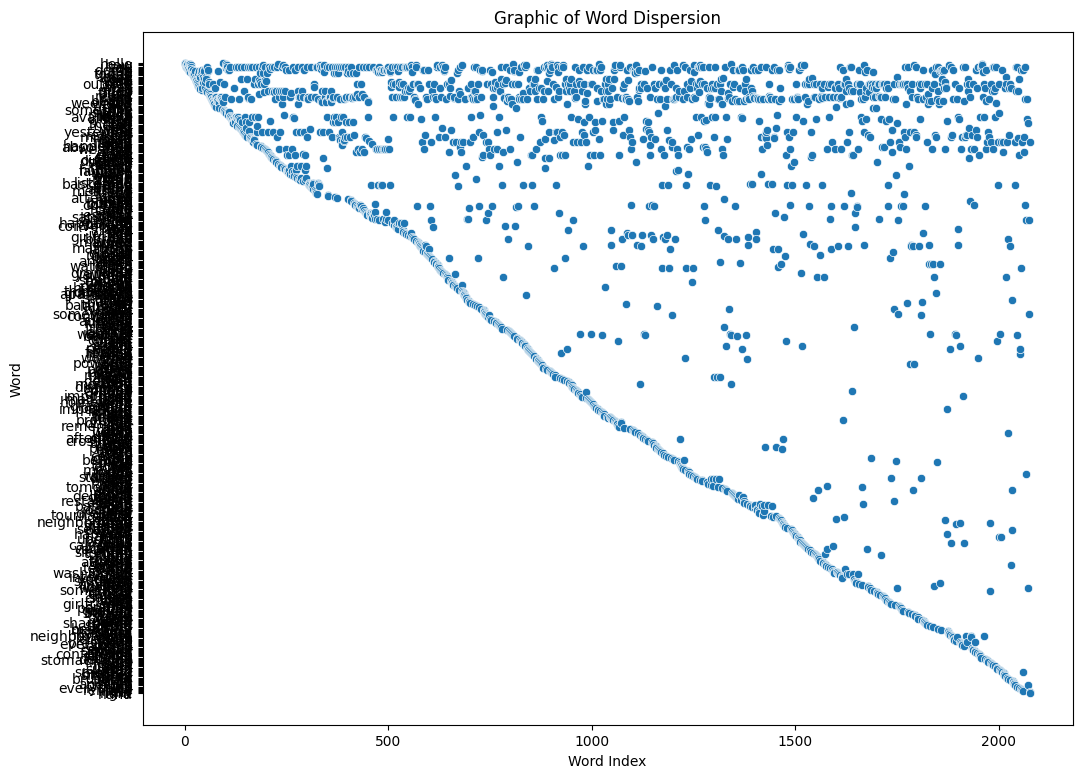

In [83]:
# word dispersion:
from itertools import chain
tokens = list(chain.from_iterable(train_df['questions'].apply(lambda x: x.split())))
plt.figure(figsize=(12, 9))
sns.scatterplot(x=range(len(tokens)), y=tokens)
plt.title('Graphic of Word Dispersion')
plt.xlabel('Word Index')
plt.ylabel('Word')
plt.show()

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [6]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

In [7]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [8]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData(url_train, 'questions', 'answers', False)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

In [9]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

In [269]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [270]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [10]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

In [35]:
MAX_LENGTH = 22

In [12]:
def infer_sentence(encoder, decoder, sentence, input_lang, output_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size(1)

        encoder.eval()
        decoder.eval()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_input = torch.tensor([[SOS_token]], device=device)  # Início de sentença

        decoded_words = []
        decoder_attentions = []

        decoder_hidden = encoder_hidden

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_attentions.append(decoder_attention.squeeze().cpu().detach().numpy())

            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions

In [13]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Reading lines...
Read 350 sentence pairs
Trimmed to 349 sentence pairs
Counting words...
Counted words:
questions 567
answers 462
0m 1s (- 0m 34s) (5 3%) 2.2613
0m 2s (- 0m 29s) (10 6%) 1.5562
0m 3s (- 0m 27s) (15 10%) 1.3340
0m 3s (- 0m 25s) (20 13%) 1.0978
0m 4s (- 0m 24s) (25 16%) 0.8639
0m 5s (- 0m 23s) (30 20%) 0.6593
0m 6s (- 0m 22s) (35 23%) 0.4910
0m 7s (- 0m 21s) (40 26%) 0.3600
0m 8s (- 0m 19s) (45 30%) 0.2551
0m 9s (- 0m 18s) (50 33%) 0.1773
0m 10s (- 0m 17s) (55 36%) 0.1198
0m 11s (- 0m 16s) (60 40%) 0.0821
0m 12s (- 0m 15s) (65 43%) 0.0577
0m 13s (- 0m 14s) (70 46%) 0.0422
0m 14s (- 0m 14s) (75 50%) 0.0330
0m 14s (- 0m 13s) (80 53%) 0.0265
0m 15s (- 0m 12s) (85 56%) 0.0222
0m 16s (- 0m 11s) (90 60%) 0.0190
0m 17s (- 0m 10s) (95 63%) 0.0163
0m 18s (- 0m 9s) (100 66%) 0.0143
0m 19s (- 0m 8s) (105 70%) 0.0128
0m 20s (- 0m 7s) (110 73%) 0.0113
0m 21s (- 0m 6s) (115 76%) 0.0105
0m 22s (- 0m 5s) (120 80%) 0.0096
0m 23s (- 0m 4s) (125 83%) 0.0088
0m 24s (- 0m 3s) (130 86%) 0.0082

<Figure size 640x480 with 0 Axes>

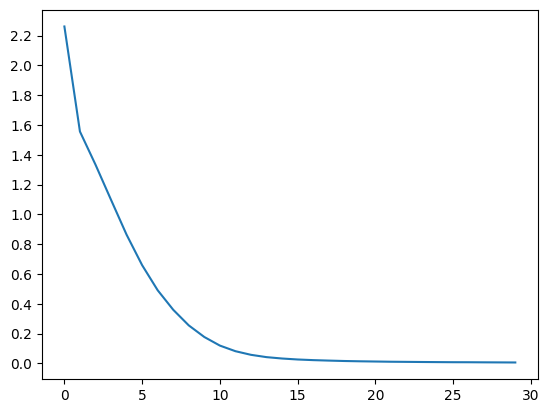

In [275]:
hidden_size = 256
batch_size = 64

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 150, print_every=5, plot_every=5)

In [280]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> that is going on
= not much
< nothing really how about you <EOS>

> did you go to the basketball game on friday
= no i could not make it
< no i could not make it <EOS>

> did you watch that golf tournament
= the one that tiger won
< the one that tiger won won <EOS>

> i have to hang up i am so sleepy
= it is not even oclock
< it is not even oclock even call it is going to be even call right it

> does your girlfriend ever make you angry
= sometimes
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> you are driving too fast
= why do you say that
< i am in a hurry <EOS>

> i am really glad that you came to see me
= i had to i was missing you a lot
< i had to i was missing you a lot <EOS>

> i will be glad when winter comes
= why is that
< why is that <EOS>

> spring break starts tomorrow
= are you going to go anywhere
< SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS

> hi how are you is alice there
= speaking that is up
< speaking that is up <EOS>



In [ ]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.set_yticklabels([''] + output_words)
    ax.set_yticklabels([''] + output_words)

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    # showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

text = clean_text("hi, how are you doing?")

evaluateAndShowAttention(text)

text = clean_text("did you hear the news?")

evaluateAndShowAttention(text)



In [282]:
torch.save(encoder.state_dict(), 'encoder_chatbot.pth')
torch.save(decoder.state_dict(), 'decoder_chatbot.pth')

In [284]:
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

encoder.load_state_dict(torch.load('encoder_chatbot.pth'))
decoder.load_state_dict(torch.load('decoder_chatbot.pth'))

<All keys matched successfully>

In [110]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('You said: ', input_sentence)
    print('response: ', ' '.join(output_words))
    # showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
    return output_words

In [129]:
from gtts import gTTS
import speech_recognition as sr
import os
import time
import sys
from audioplayer import AudioPlayer


tts = gTTS(text="Initialization complete", lang="en")
tts.save("said.mp3")
AudioPlayer("said.mp3").play(block=True)


def main():
    while True:
        mic = sr.Recognizer()
        mic.pause_threshold = 2.4
        with sr.Microphone() as source:
            mic.adjust_for_ambient_noise(source)
            source.SAMPLE_WIDTH = 2
            print("speak...")
            audio  = mic.listen(source)
        try:
            # comando = mic.recognize_google(audio, language="pt-br" or "en-us")
            comando = mic.recognize_google(audio, language="en-us")
            print(f"Você disse: {comando}")
        except sr.UnknownValueError:
            tts = gTTS(text="sorry, i couldn't understand", lang="en")
            tts.save("said.mp3")
            AudioPlayer("said.mp3").play(block=True)
            main()
        except sr.RequestError as e:
            print("Could not request results from Google Speech Recognition service; {0}".format(e))
            main()

        if len(comando) > 0:
            query = comando.lower()
            query = clean_text(query)
            if "exit" in query:
                tts = gTTS(text="finishing execution proccess", lang="en")
                tts.save("said.mp3")
                AudioPlayer("said.mp3").play(block=True)                
                break
            else:
                resp = evaluateAndShowAttention(query)
                resp = str(resp)
                resp = resp.replace('<EOS>', '')
                tts = gTTS(text=resp, lang="en")
                tts.save("said.mp3")
                AudioPlayer("said.mp3").play(block=True)
        else:
            main()

main()

speak...
Você disse: Hi how are you doing
You said:  hi how are you doing
response:  i am fine how about yourself <EOS>
speak...
Você disse: it is such a nice day
You said:  it is such a nice day
response:  yes it is <EOS>
speak...
Você disse: is Alice available
You said:  is alice available
response:  you are talking to her <EOS>
speak...
Você disse: did you go to the basketball game on Friday
You said:  did you go to the basketball game on friday
response:  no i could not make it <EOS>
speak...
Você disse: did you hear the news
You said:  did you hear the news
response:  what happened <EOS>
speak...
Você disse: it was nice talking to you
You said:  it was nice talking to you
response:  why are you trying to rush me off the phone so fast <EOS>
speak...
Você disse: exit


# Better Data

In [88]:
name_data = 'human_chat.txt'
url_train = path_downloads / name_data

In [89]:
def read_lines(input, output, url_train, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(url_train, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = []
    current_pair = ['', '']  # Initialize an empty pair
    for line in lines:
        if line.startswith('Human 1:'):
            current_pair[0] = clean_text(line[len('Human 1:'):].strip())
        elif line.startswith('Human 2:'):
            current_pair[1] = clean_text(line[len('Human 2:'):].strip())
            pairs.append(current_pair)
            current_pair = ['', '']  # Reset the pair for the next iteration

    # Reverse pairs, make instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input = DataPreproccessing(output)
        output = DataPreproccessing(input)
    else:
        input = DataPreproccessing(input)
        output = DataPreproccessing(output)

    return input, output, pairs

In [90]:
MAX_LENGTH = 25

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [91]:
def prepareData(url_train, input, output, reverse=False):
    input, output, pairs = read_lines(input, output, url_train, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("We trimmed %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input.addSentence(pair[0])
        output.addSentence(pair[1])
    print("Counted words:")
    print(input.name, input.n_words)
    print(output.name, output.n_words)
    return input, output, pairs

input, output, pairs = prepareData(url_train, 'questions', 'answers', False)
print(random.choice(pairs))

Reading lines...
Read 741 sentence pairs
We trimmed 575 sentence pairs
Counting words...
Counted words:
questions 1220
answers 1253
['i do a lot of different kinds', 'cool i wanna see it someday']


In [92]:
train_df = pd.DataFrame(pairs, columns=['questions', 'answers'])  # it's not much data but is ok for didatic purposes
display(train_df)

questions  \
0                                                   hi   
1     one where i get to meet lots of different people   
2                          hard to keep a count maybe    
3                             i think it was australia   
4                           hi there how are you today   
..                                                 ...   
570  i am looking through some old photos of my hom...   
571  it is called redactedterm on the north coast o...   
572      yes that would be nice do you like travelling   
573       where would you most like to go if you could   
574  wow cool i think space tourism is going to be ...   

                                               answers  
0                        what is your favorite holiday  
1    what was the most number of people you have ev...  
2                               which holiday was that  
3              do you still talk to the people you met  
4    i am doing well thank you for asking how about...  
..                                                 ...  
570  i feel you memeories always flood when looking...  
571   hope you can take some time to visit pretty soon  
572       yes i do but haven t been to many places yet  
573                              fly to the moon  haha  
574              yep i believe there is a day for that  

[575 rows x 2 columns]

In [93]:
max_length = train_df.map(len).max(axis=1).max()
print("max length of a line in DataFrame:", max_length)

max length of a line in DataFrame: 138


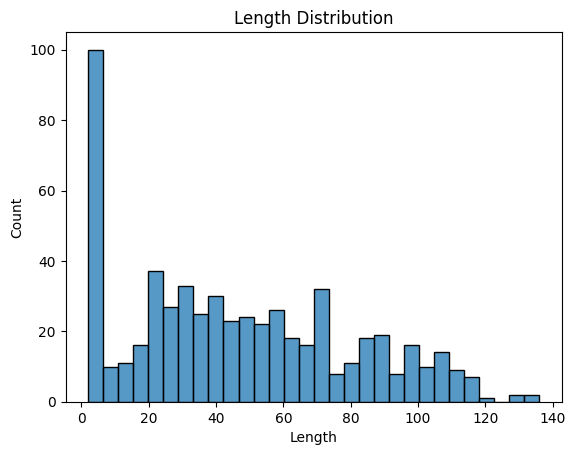

In [94]:
sns.histplot(data=train_df['questions'].str.len(), bins=30)
plt.title('Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

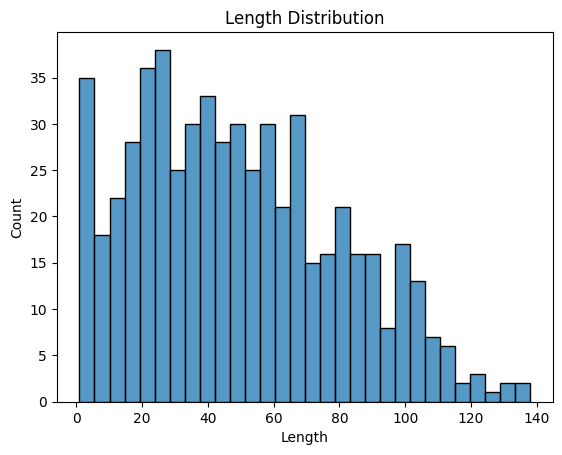

In [95]:
sns.histplot(data=train_df['answers'].str.len(), bins=30)
plt.title('Length Distribution')
plt.xlabel('Length')
plt.ylabel('Count')
plt.show()

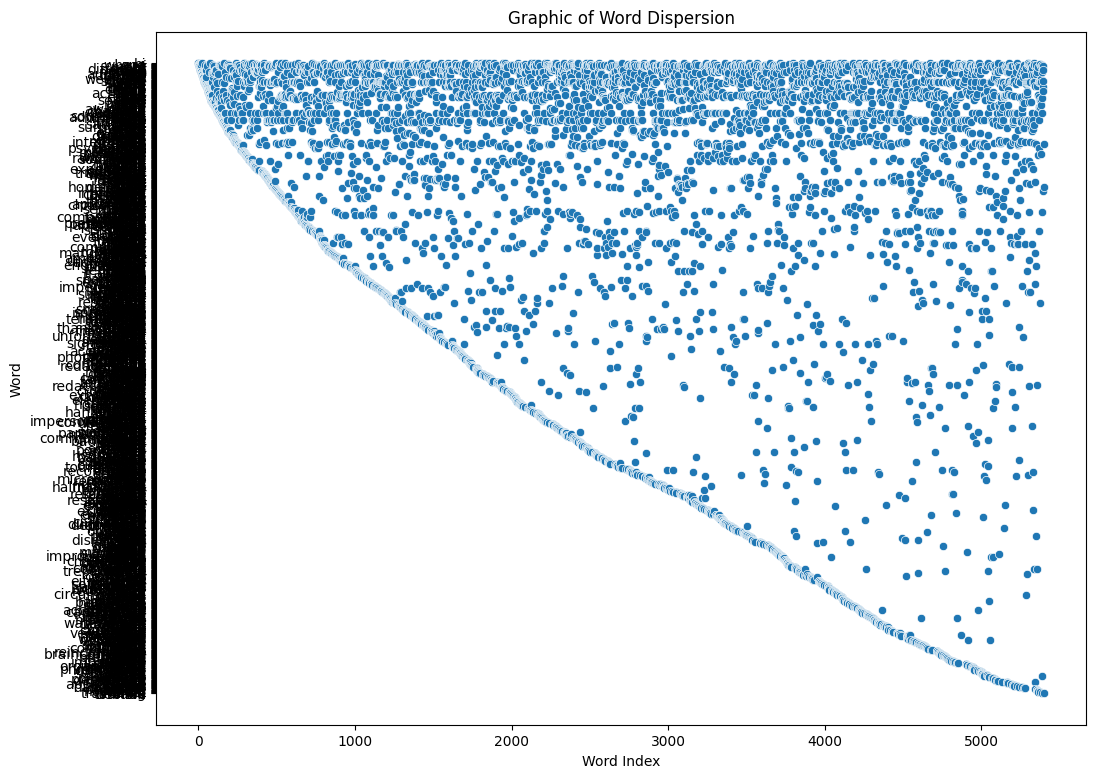

In [42]:
# word dispersion:
from itertools import chain
tokens = list(chain.from_iterable(train_df['questions'].apply(lambda x: x.split())))
plt.figure(figsize=(12, 9))
sns.scatterplot(x=range(len(tokens)), y=tokens)
plt.title('Graphic of Word Dispersion')
plt.xlabel('Word Index')
plt.ylabel('Word')
plt.show()

In [27]:
# everything in a script

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import time
import math
import torch.nn as nn
import torch.nn.functional as F

SOS_token = 0
EOS_token = 1
MAX_LENGTH = 25

class NLPChatBot(nn.Module):
    def __init__(self, input_lang, output_lang, hidden_size=512, batch_size=64):
        super(NLPChatBot, self).__init__()

        self.input_lang = input_lang
        self.output_lang = output_lang
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.device = device

        self.encoder = EncoderRNN(input_lang.n_words, hidden_size)
        self.decoder = AttnDecoderRNN(hidden_size, output_lang.n_words)

    def forward(self, input_tensor, target_tensor):
        encoder_outputs, encoder_hidden = self.encoder(input_tensor)
        decoder_outputs, _, _ = self.decoder(encoder_outputs, encoder_hidden, target_tensor)
        return decoder_outputs

    def indexesFromSentence(self, lang, sentence):
        return [lang.word2index[word] for word in sentence.split(' ')]

    def tensorFromSentence(self, lang, sentence):
        indexes = self.indexesFromSentence(lang, sentence)
        indexes.append(EOS_token)
        return torch.tensor(indexes, dtype=torch.long, device=self.device).view(1, -1)

    def tensorsFromPair(self, pair):
        input_tensor = self.tensorFromSentence(self.input_lang, pair[0])
        target_tensor = self.tensorFromSentence(self.output_lang, pair[1])
        return (input_tensor, target_tensor)

    def get_dataloader(self):
        n = len(pairs)
        input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
        target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

        for idx, (inp, tgt) in enumerate(pairs):
            inp_ids = self.indexesFromSentence(self.input_lang, inp)
            tgt_ids = self.indexesFromSentence(self.output_lang, tgt)
            inp_ids.append(EOS_token)
            tgt_ids.append(EOS_token)
            input_ids[idx, :len(inp_ids)] = inp_ids
            target_ids[idx, :len(tgt_ids)] = tgt_ids

        train_data = TensorDataset(torch.LongTensor(input_ids).to(self.device),
                                   torch.LongTensor(target_ids).to(self.device))

        train_sampler = RandomSampler(train_data)
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=self.batch_size)
        return train_dataloader

    def train_epoch(self, dataloader, encoder_optimizer, decoder_optimizer, criterion):
        total_loss = 0
        for data in dataloader:
            input_tensor, target_tensor = data

            encoder_optimizer.zero_grad()
            decoder_optimizer.zero_grad()

            encoder_outputs, encoder_hidden = self.encoder(input_tensor)
            decoder_outputs, _, _ = self.decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(
                decoder_outputs.view(-1, decoder_outputs.size(-1)),
                target_tensor.view(-1)
            )
            loss.backward()

            encoder_optimizer.step()
            decoder_optimizer.step()

            total_loss += loss.item()

        return total_loss / len(dataloader)

    def train(self, train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
        train_dataloader = self.get_dataloader()

        start = time.time()
        plot_losses = []
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every

        encoder_optimizer = torch.optim.Adam(self.encoder.parameters(), lr=learning_rate)
        decoder_optimizer = torch.optim.Adam(self.decoder.parameters(), lr=learning_rate)
        criterion = nn.NLLLoss()

        for epoch in range(1, n_epochs + 1):
            loss = self.train_epoch(train_dataloader, encoder_optimizer, decoder_optimizer, criterion)
            print_loss_total += loss
            plot_loss_total += loss

            if epoch % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (self.timeSince(start, epoch / n_epochs),
                                            epoch, epoch / n_epochs * 100, print_loss_avg))

            if epoch % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0

        self.showPlot(plot_losses)

    def timeSince(self, since, percent):
        now = time.time()
        s = now - since
        es = s / (percent)
        rs = es - s
        return '%s (- %s)' % (self.asMinutes(s), self.asMinutes(rs))

    def asMinutes(self, s):
        m = math.floor(s / 60)
        s -= m * 60
        return '%dm %ds' % (m, s)

    def showPlot(self, points):
        import matplotlib.pyplot as plt
        import matplotlib.ticker as ticker
        import numpy as np

        plt.figure()
        fig, ax = plt.subplots()
        loc = ticker.MultipleLocator(base=0.2)
        ax.yaxis.set_major_locator(loc)
        plt.plot(points)
        plt.show()

    class EncoderRNN(nn.Module):
        def __init__(self, input_size, hidden_size, dropout_p=0.1):
            super(EncoderRNN, self).__init__()
            self.hidden_size = hidden_size

            self.embedding = nn.Embedding(input_size, hidden_size)
            self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
            self.dropout = nn.Dropout(dropout_p)

        def forward(self, input):
            embedded = self.dropout(self.embedding(input))
            output, hidden = self.gru(embedded)
            return output, hidden

    class DecoderRNN(nn.Module):
        def __init__(self, hidden_size, output_size):
            super(DecoderRNN, self).__init__()
            self.embedding = nn.Embedding(output_size, hidden_size)
            self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
            self.out = nn.Linear(hidden_size, output_size)

        def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
            batch_size = encoder_outputs.size(0)
            decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=self.device).fill_(SOS_token)
            decoder_hidden = encoder_hidden
            decoder_outputs = []

            for i in range(MAX_LENGTH):
                decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
                decoder_outputs.append(decoder_output)

                if target_tensor is not None:
                    # Teacher forcing: Feed the target as the next input
                    decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
                else:
                    # Without teacher forcing: use its own predictions as the next input
                    _, topi = decoder_output.topk(1)
                    decoder_input = topi.squeeze(-1).detach()  # detach from history as input

            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
            return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

        def forward_step(self, input, hidden):
            output = self.embedding(input)
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
            output = self.out(output)
            return output, hidden

    class BahdanauAttention(nn.Module):
        def __init__(self, hidden_size):
            super(BahdanauAttention, self).__init__()
            self.Wa = nn.Linear(hidden_size, hidden_size)
            self.Ua = nn.Linear(hidden_size, hidden_size)
            self.Va = nn.Linear(hidden_size, 1)

        def forward(self, query, keys):
            scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
            scores = scores.squeeze(2).unsqueeze(1)

            weights = F.softmax(scores, dim=-1)
            context = torch.bmm(weights, keys)

            return context, weights

    class AttnDecoderRNN(nn.Module):
        def __init__(self, hidden_size, output_size, dropout_p=0.1):
            super(AttnDecoderRNN, self).__init__()
            self.embedding = nn.Embedding(output_size, hidden_size)
            self.attention = BahdanauAttention(hidden_size)
            self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
            self.out = nn.Linear(hidden_size, output_size)
            self.dropout = nn.Dropout(dropout_p)

        def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
            batch_size = encoder_outputs.size(0)
            decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
            decoder_hidden = encoder_hidden
            decoder_outputs = []
            attentions = []

            for i in range(MAX_LENGTH):
                decoder_output, decoder_hidden, attn_weights = self.forward_step(
                    decoder_input, decoder_hidden, encoder_outputs
                )
                decoder_outputs.append(decoder_output)
                attentions.append(attn_weights)

                if target_tensor is not None:
                    # Teacher forcing: Feed the target as the next input
                    decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
                else:
                    # Without teacher forcing: use its own predictions as the next input
                    _, topi = decoder_output.topk(1)
                    decoder_input = topi.squeeze(-1).detach()  # detach from history as input

            decoder_outputs = torch.cat(decoder_outputs, dim=1)
            decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
            attentions = torch.cat(attentions, dim=1)

            return decoder_outputs, decoder_hidden, attentions


        def forward_step(self, input, hidden, encoder_outputs):
            embedded =  self.dropout(self.embedding(input))

            query = hidden.permute(1, 0, 2)
            context, attn_weights = self.attention(query, encoder_outputs)
            input_gru = torch.cat((embedded, context), dim=2)

            output, hidden = self.gru(input_gru, hidden)
            output = self.out(output)

            return output, hidden, attn_weights


input, output, train_dataloader = get_dataloader(batch_size=64)

model = NLPChatBot(input, output)
model.to(device)
model

Reading lines...
Read 741 sentence pairs
We trimmed 575 sentence pairs
Counting words...
Counted words:
questions 1220
answers 1253


NLPChatBot(
  (encoder): EncoderRNN(
    (embedding): Embedding(1220, 512)
    (gru): GRU(512, 512, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(1253, 512)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=True)
    )
    (gru): GRU(1024, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=1253, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [114]:
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

6,373,094 total parameters.
6,373,094 training parameters.



Reading lines...
Read 741 sentence pairs
We trimmed 575 sentence pairs
Counting words...
Counted words:
questions 1220
answers 1253
0m 2s (- 0m 56s) (5 5%) 2.5281
0m 5s (- 0m 50s) (10 10%) 1.6971
0m 8s (- 0m 46s) (15 15%) 1.0707
0m 10s (- 0m 43s) (20 20%) 0.5426
0m 13s (- 0m 40s) (25 25%) 0.2418
0m 16s (- 0m 37s) (30 30%) 0.1177
0m 18s (- 0m 35s) (35 35%) 0.0715
0m 21s (- 0m 32s) (40 40%) 0.0538
0m 24s (- 0m 29s) (45 45%) 0.0455
0m 26s (- 0m 26s) (50 50%) 0.0408
0m 29s (- 0m 24s) (55 55%) 0.0378
0m 32s (- 0m 21s) (60 60%) 0.0357
0m 34s (- 0m 18s) (65 65%) 0.0344
0m 37s (- 0m 16s) (70 70%) 0.0332
0m 40s (- 0m 13s) (75 75%) 0.0325
0m 42s (- 0m 10s) (80 80%) 0.0318
0m 45s (- 0m 8s) (85 85%) 0.0309
0m 48s (- 0m 5s) (90 90%) 0.0308
0m 50s (- 0m 2s) (95 95%) 0.0301
0m 53s (- 0m 0s) (100 100%) 0.0299


<Figure size 640x480 with 0 Axes>

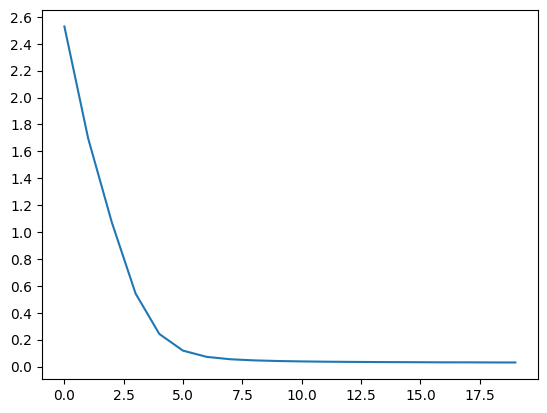

In [115]:
input_lang, output_lang, train_dataloader = get_dataloader(batch_size=64)

# Treine o modelo usando a função train da BaseModel
model.train(train_dataloader, model.encoder, model.decoder, 100, print_every=5, plot_every=5)

In [116]:
model.encoder.eval()
model.decoder.eval()
evaluateRandomly(model.encoder, model.decoder)

> i know right are you taking history next semester
= no i am not in school anymore
< no i am not in school anymore <EOS>

> hahaha that is a great way to put it
= you should definitely try tubing the next time you head towards the mountains during the winter
< you should definitely try tubing the next time you head towards the mountains during the winter <EOS>

> yes i do you act like a robot how about me am i like a robot
= a little bit haha
< a little bit haha <EOS>

> no shame in that best part is you can claim you are eating vegetables as you enjoy it what do you do for work
= i m a professional dancer
< i m a professional dancer <EOS>

> yes that would be nice do you like travelling
= yes i do but haven t been to many places yet
< yes i do but haven t been to many places yet <EOS>

> hi can you recommend some good netflix shows
= i really enjoyed white collar on netflix do you watch a lot of tv shows
< i really enjoyed white collar on netflix do you watch a lot of tv shows do you

In [130]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model.encoder, model.decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    # showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
    return output_words

In [139]:
from gtts import gTTS
import speech_recognition as sr
import os
import time
import sys
from audioplayer import AudioPlayer


tts = gTTS(text="Initialization complete", lang="en")
tts.save("said.mp3")
AudioPlayer("said.mp3").play(block=True)


def main():
    while True:
        mic = sr.Recognizer()
        mic.pause_threshold = 1.7
        with sr.Microphone() as source:
            mic.adjust_for_ambient_noise(source)
            source.SAMPLE_WIDTH = 2
            print("speak...")
            audio  = mic.listen(source)
        try:
            # comando = mic.recognize_google(audio, language="pt-br" or "en-us")
            comando = mic.recognize_google(audio, language="en-us")
            print(f"Você disse: {comando}")
        except sr.UnknownValueError:
            tts = gTTS(text="sorry, i couldn't understand", lang="en")
            tts.save("said.mp3")
            AudioPlayer("said.mp3").play(block=True)
            main()
        except sr.RequestError as e:
            print("Could not request results from Google Speech Recognition service; {0}".format(e))
            main()

        if len(comando) > 0:
            query = comando.lower()
            query = clean_text(query)
            if "exit" in query:
                tts = gTTS(text="finishing execution proccess", lang="en")
                tts.save("said.mp3")
                AudioPlayer("said.mp3").play(block=True)                
                break
            else:
                try:
                    resp = evaluateAndShowAttention(query)
                    resp = str(resp)
                    resp = resp.replace('<EOS>', '0')
                    resp = clean_text(resp)
                    if 'SOS' in resp:
                        resp = clean_text("i don't have a right answer to that")
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)
                except KeyError as exception:
                    resp = clean_text("i don't know one of the words you said")
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)
        else:
            main()

main()

speak...
Você disse: hi there how are you today
input = hi there how are you today
output = i am doing well thank you for asking how about you <EOS>
speak...
Você disse: I'm great I'm just starting to work on your project that I'm really excited about
input = i am great i am just starting to work on your project that i am really excited about
output = that sounds awesome what is the project about <EOS>
speak...
Você disse: it uses a machine learning algorithm called natural language processing NLP to understand and respond to user input
input = it uses a machine learning algorithm called natural language processing nlp to understand and respond to user input
output = that is fascinating i have always been interested in nlp nlp what is your favorite flower preference <EOS>
speak...
Você disse: it uses a machine learning algorithm called natural language processing to understand and respond to user input
input = it uses a machine learning algorithm called natural language processing to u

In [147]:
from gtts import gTTS
import speech_recognition as sr
import os
import time
import sys
from audioplayer import AudioPlayer


tts = gTTS(text="Initialization complete", lang="en")
tts.save("said.mp3")
AudioPlayer("said.mp3").play(block=True)


def main():
    while True:
        mic = sr.Recognizer()
        mic.pause_threshold = 1.7
        with sr.Microphone() as source:
            mic.adjust_for_ambient_noise(source)
            source.SAMPLE_WIDTH = 2
            print("speak...")
            audio  = mic.listen(source)
        try:
            # comando = mic.recognize_google(audio, language="pt-br" or "en-us")
            comando = mic.recognize_google(audio, language="en-us")
            print(f"Você disse: {comando}")
        except sr.UnknownValueError:
            tts = gTTS(text="sorry, i couldn't understand", lang="en")
            tts.save("said.mp3")
            AudioPlayer("said.mp3").play(block=True)
            main()
        except sr.RequestError as e:
            print("Could not request results from Google Speech Recognition service; {0}".format(e))
            main()

        if len(comando) > 0:
            query = comando.lower()
            query = clean_text(query)
            if "exit" in query:
                tts = gTTS(text="finishing execution proccess", lang="en")
                tts.save("said.mp3")
                AudioPlayer("said.mp3").play(block=True)                
                break
            else:
                try:
                    resp = evaluateAndShowAttention(query)
                    resp = str(resp)
                    resp = resp.replace('<EOS>', '0')
                    resp = clean_text(resp)
                    if 'sos' in resp:
                        resp = clean_text("i don't have a right answer to that")
                        print(resp)
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)
                except KeyError as exception:
                    resp = clean_text("i don't know one of the words you said")
                    print(resp)
                    tts = gTTS(text=resp, lang="en")
                    tts.save("said.mp3")
                    AudioPlayer("said.mp3").play(block=True)
        else:
            main()

main()

speak...
Você disse: hello there how are you
input = hello there how are you
output = i am doing good just having some morning tea <EOS>
speak...
Você disse: and why are you planning to do
input = and why are you planning to do
output = i m a professional dancer <EOS>
speak...
Você disse: so you like to dance
input = so you like to dance
output = i am true fan well anyways let me know how the repair work goes i need to run now for a meeting ttyl <EOS>
speak...
Você disse: I have a lot of meetings
input = i have a lot of meetings
output = SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS
i do not have a right answer to that
speak...
Você disse: I should go back to work now it was nice chatting with you
input = i should go back to work now it was nice chatting with you
output = you too <EOS>
speak...
Você disse: bye
input = bye
output = bye <EOS>
speak...
Você disse: exit


input = hello how are you doing
output = i am doing ok looking forwards to the weekend how about you <EOS>


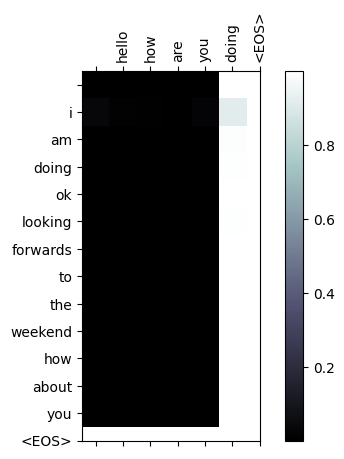

input = what food do you like to eat
output = thanks for lunch on wednesdays <EOS>


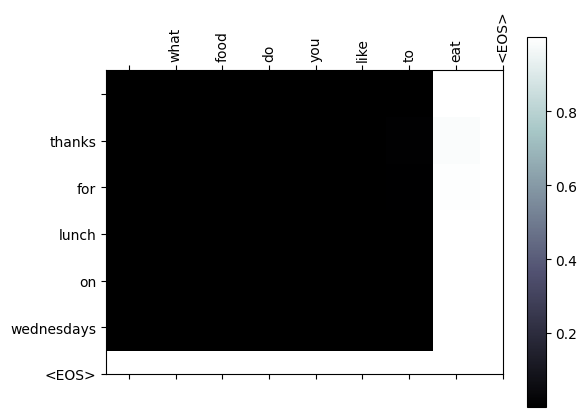

input = the virtual reality is actually based on a real alien civilization and that civilization is coming to attack earth dun dun dun dunnnnnnn
output = woah that is fascinating i will have to pick up a copy copy copy sure SOS SOS SOS SOS SOS SOS SOS SOS SOS SOS


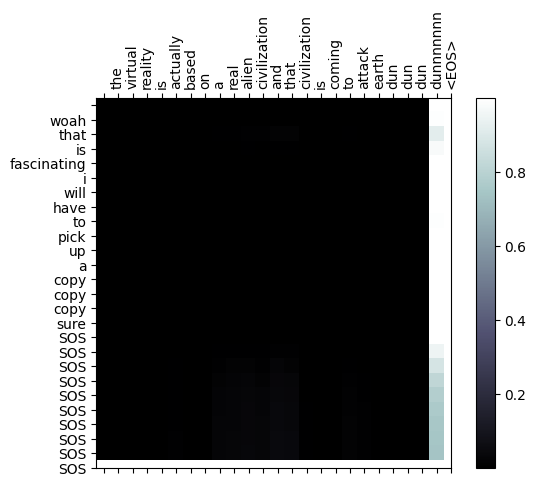

input = haha forget it what else do you like to do beside work
output = lots of fun stuff eating sleeping   <EOS>


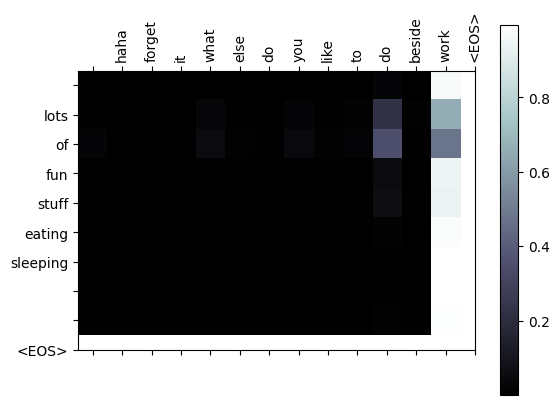

In [100]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Definir os ticks para evitar UserWarnings
    ax.set_xticks(range(len(input_sentence.split(' ')) + 2))
    ax.set_yticks(range(len(output_words) + 1))

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.set_yticklabels([''] + output_words)

    plt.show()

def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(model.encoder, model.decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

text = clean_text("hello, how are you doing?")

evaluateAndShowAttention(text)

text = clean_text("what food do you like to eat?")

evaluateAndShowAttention(text)

text = clean_text("The virtual reality is actually based on a real alien civilization! And that civilization is coming to attack earth! dun dun dun dunnnnnnn")

evaluateAndShowAttention(text)

text = clean_text("haha, forget it. what else do you like to do beside work?")

evaluateAndShowAttention(text)

In [101]:
from pathlib import Path

# save the model state dict and optimizers
def save(model, model_path, encoder_optimizer, decoder_optimizer, epoch, loss):
    torch.save({
        'model_state_dict': model.state_dict(),
        'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
        'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
        'epoch': epoch,  # Salve o número da última época se aplicável
        'loss': loss,    # Salve a última loss se aplicável
    }, model_path)
    return print(f"Saved the model and optimizers to {model_path}")

In [102]:
MODEL_NAME = 'PyTorch_ChatBotNN.pth'
MODEL_SAVE_PATH = path_downloads / MODEL_NAME

In [ ]:
epoch = False
loss = False
save(model=model, model_path=MODEL_SAVE_PATH, encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer, epoch=epoch if epoch else False, loss=loss if loss else False)

In [83]:
def loading(model_path, device, model, class_name, encoder_optim, decoder_optim):
    # Carregamento do modelo
    checkpoint = torch.load(model_path, map_location=torch.device(device)) 
    
    input, output, train_dataloader = get_dataloader(batch_size=64)
    
    # Crie uma instância do modelo com a classe fornecida
    model = class_name(input, output) 
    
    # Carregue o estado do modelo
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Crie os otimizadores com os parâmetros do modelo
    encoder_optim = torch.optim.Adam(params=model.encoder.parameters(),
                                     lr=0.001)
    decoder_optim = torch.optim.Adam(params=model.decoder.parameters(),
                                     lr=0.001)
    
    # Carregue os estados dos otimizadores
    encoder_optim.load_state_dict(checkpoint['encoder_optimizer_state_dict'])
    decoder_optim.load_state_dict(checkpoint['decoder_optimizer_state_dict'])
    
    # Recupere informações sobre a última época e loss se aplicável
    epoch = checkpoint['epoch'] if 'epoch' in checkpoint else 0
    loss = checkpoint['loss'] if 'loss' in checkpoint else None
    
    # Mova o modelo e os otimizadores para o dispositivo desejado
    model.to(device)
    
    return model

In [69]:
encoder_optimizer = torch.optim.Adam(params=model.encoder.parameters(),
                            lr=0.001)
decoder_optimizer = torch.optim.Adam(params=model.decoder.parameters(),
                            lr=0.001)

In [84]:
test = loading(model_path=MODEL_SAVE_PATH, device=device, model=model, class_name=NLPChatBot, encoder_optim=encoder_optimizer, decoder_optim=decoder_optimizer)
test

Reading lines...
Read 730 sentence pairs
We trimmed 566 sentence pairs
Counting words...
Counted words:
questions 1201
answers 1250


NLPChatBot(
  (encoder): EncoderRNN(
    (embedding): Embedding(1201, 512)
    (gru): GRU(512, 512, batch_first=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(1250, 512)
    (attention): BahdanauAttention(
      (Wa): Linear(in_features=512, out_features=512, bias=True)
      (Ua): Linear(in_features=512, out_features=512, bias=True)
      (Va): Linear(in_features=512, out_features=1, bias=True)
    )
    (gru): GRU(1024, 512, batch_first=True)
    (out): Linear(in_features=512, out_features=1250, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [85]:
test.encoder.eval()
test.decoder.eval()
evaluateRandomly(test.encoder, test.decoder)

> i am working on a theory why does the lotus spring to mind
= nice lotus looks pretty cool and it has some delightful vibe so what is this research about
< nice lotus looks pretty cool and it has some delightful vibe so what is this research about <EOS>

> pretty good just went to church and hangout with friends
= nice
< nice <EOS>

> hi
= i was talking to robot all the time
< hey <EOS>

> likewise wanted to know if you and the kids would want to join us for disneyland trip around christmas
= oh wow that sounds like so much fun definitely count us in what is your plan
< oh wow that sucks  by itself then <EOS>

> the disney lands are all different theres also disney sea which is completely unique
= oh neat i have not heard about that robot fighting show where is that
< oh neat i have not heard about that robot fighting show where is that <EOS>

> ok step is you ask someone what their favourite flower is pretty much like what we just did does that make sense so far
= yes
< yes <EOS>

> 

# We could do some data augmentation, concatenate the two datasets for more data, we can even use custom data to give more purpose to the model, but the main objective is done, i plan to use pyotrch modularization to mix things and do bigger and more complex things